In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/us-patent-p

# Loading Dependencies and Configuring TPU's 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, RNN
from tensorflow.keras.layers import Dense, Activation,Embedding,BatchNormalization, LayerNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from plotly import graph_objs as go
#import plotly.express as px
#import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1736283074.748618      13 service.cc:145] XLA service 0x58a55f9da660 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736283074.748668      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1736283074.748672      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1736283074.748674      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1736283074.748677      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1736283074.748679      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1736283074.748682      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1736283074.748684      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1736283074.748687      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


# 2. Problem Phrasing

Upon review the data in train, validation and test, there are two main tasks we need to work on :
- Develop a NLP model to solve this text classification problem, to categorize comments into toxic or non-toxic group
- Given train dataset contains only English comment, however validation and test datasets have only non-English comments, therefore we need use and deploy a multilingual models with English-only training data.

In [4]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [5]:
validation['lang'].unique(),test['lang'].unique()

(array(['es', 'it', 'tr'], dtype=object),
 array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object))

In [6]:
train = train.drop(columns = ['severe_toxic','obscene','threat','insult','identity_hate'])
train = train.iloc[:12000,:]
xtrain,xvalid,ytrain,yvalid = train_test_split(train['comment_text'].values,train['toxic'],stratify=train.toxic.values,test_size = 0.25,random_state = 42)

# 3. Data Preprocessing
There are key steps for NLP data preparation, based on varied models' need, we will have more targeted data preparation.

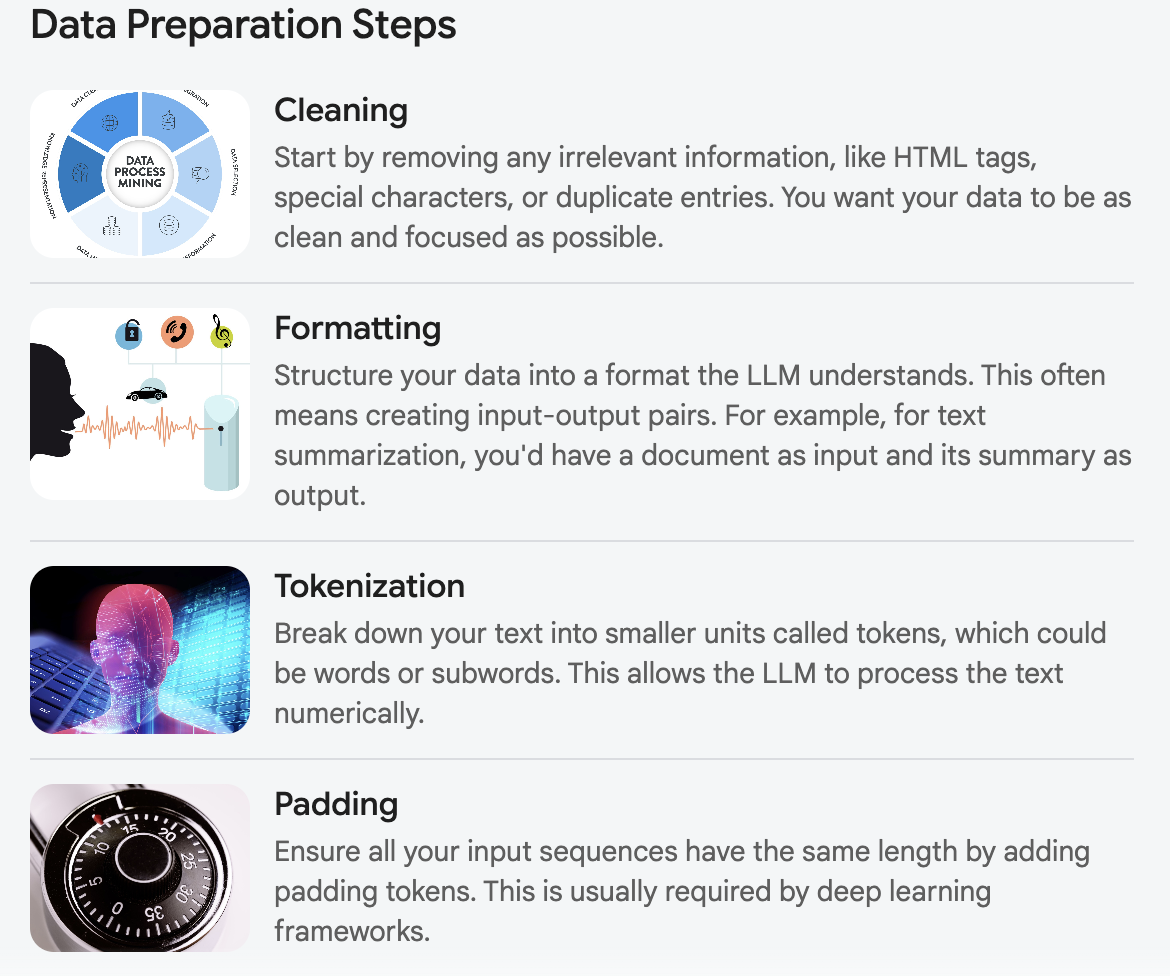 



# 4. Modeling
## 4.1 LSTM
Data Preparation for RNN model: 
1. Tokenization: Create numerical representation for each comment
2. Padding: RNN requires fixed lenght of input

Tokenization is to 
create tokenizer object for text preprocessing. Tokenizer first fits all your text data and convert sentences into sequence of integers based on frequency of unique words.

In [7]:
token = Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

import itertools
dict(itertools.islice(word_index.items(),10))

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10}

In [8]:
xtrain[8999],xtrain_seq[8999],xtrain_pad[8999]

('"\n\nElvis... Crying in the Chapel  Feudalist  "',
 [9624, 5247, 10, 1, 37799, 11631],
 array([    0,     0,     0, ...,     1, 37799, 11631], dtype=int32))

In [9]:
%%time
with strategy.scope():
    # A simpleLSTM without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

I0000 00:00:1736283084.413032      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

CPU times: user 585 ms, sys: 56.8 ms, total: 642 ms
Wall time: 607 ms


In [10]:
model.fit(xtrain_pad,ytrain,epochs = 5,batch_size = 64 * strategy.num_replicas_in_sync)
scores = model.predict(xvalid_pad)

score_list = []
score_list.append({'Model': 'Vocabulaty + LSTM', 'AUC_score':roc_auc_score(yvalid,scores)})
score_list

Epoch 1/5


2025-01-07 20:51:32.743653: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1736283093.021820     832 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1e47df72848b0914:0:0), session_name()
I0000 00:00:1736283097.329983     832 tpu_compile_op_common.cc:245] Compilation of 1e47df72848b0914:0:0 with session name  took 4.308123957s and succeeded
I0000 00:00:1736283097.338361     832 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1e47df72848b0914:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4807983090861672324", property.function_library_fingerprint = 12455599839410804721, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z =

17/18 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8251 - loss: 0.5800

I0000 00:00:1736283137.592370     779 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(feb5c3249b01cbce:0:0), session_name()
I0000 00:00:1736283141.172496     779 tpu_compile_op_common.cc:245] Compilation of feb5c3249b01cbce:0:0 with session name  took 3.58007699s and succeeded
I0000 00:00:1736283141.178538     779 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(feb5c3249b01cbce:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4807983090861672324", property.function_library_fingerprint = 12455599839410804721, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "37,1500,;37,1,;", property.guaranteed_constants_size = 0, embedding

18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8307 - loss: 0.5679
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9048 - loss: 0.2896
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9234 - loss: 0.1980
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9635 - loss: 0.1046
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9839 - loss: 0.0548


2025-01-07 20:55:11.857547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1736283311.897624     829 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(17e73f9f199875f5:0:0), session_name()


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

I0000 00:00:1736283312.166386     829 tpu_compile_op_common.cc:245] Compilation of 17e73f9f199875f5:0:0 with session name  took 268.70968ms and succeeded
I0000 00:00:1736283312.167196     829 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(17e73f9f199875f5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2695899801244182788", property.function_library_fingerprint = 14874349023001296236, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283312.167216     829 tpu_compilation_cache_interface.cc:541] After adding entry for key 17e73f9f1998

93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

I0000 00:00:1736283316.063307     807 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f677c9956ae417e8:0:0), session_name()


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step


I0000 00:00:1736283316.740007     807 tpu_compile_op_common.cc:245] Compilation of f677c9956ae417e8:0:0 with session name  took 676.648553ms and succeeded
I0000 00:00:1736283316.741257     807 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f677c9956ae417e8:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13653538976329413973", property.function_library_fingerprint = 8776013815937197732, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,1500,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283316.741280     807 tpu_compilation_cache_interface.cc:541] After adding entry for key f67

[{'Model': 'Vocabulaty + LSTM', 'AUC_score': 0.9343846584662615}]

## 4.2 GloVe Word Embedding
Use pre-trained GloVe word embedding model to train LSTM to evaluate the importance of work embedding

In [11]:
embeddings_index = {}

f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [03:40, 9957.46it/s] 

Found 2196017 word vectors.


In [12]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

100%|██████████| 43488/43488 [00:00<00:00, 267393.04it/s]


(43489, 300)

In [13]:
dict(itertools.islice(word_index.items(),1))

{'the': 1}

In [14]:
#pre-trained GLoVe embedding convert 'the' to 300 dimension vector, first 10 elements shown below
embeddings_index.get('the')[0:10]

array([ 0.27204  , -0.06203  , -0.1884   ,  0.023225 , -0.018158 ,
        0.0067192, -0.13877  ,  0.17708  ,  0.17709  ,  2.5882   ])

In [15]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    13,046,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,046,700 (49.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,046,700 (49.77 MB)

CPU times: user 609 ms, sys: 1.35 s, total: 1.96 s
Wall time: 1.5 s


In [16]:
model.fit(xtrain_pad,ytrain,epochs = 5, batch_size = 64*strategy.num_replicas_in_sync)
scores = model.predict(xvalid_pad)
score_list.append({'Model': 'GloVe + LSTM','AUC_Score': roc_auc_score(yvalid,scores)})

score_list
#By switch embedding method, 1.5% increase in AUC_score

Epoch 1/5


2025-01-07 20:59:02.629243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1736283543.119144     777 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c170710236c0d32b:0:0), session_name()


 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5884 - loss: 0.6699

I0000 00:00:1736283547.162766     777 tpu_compile_op_common.cc:245] Compilation of c170710236c0d32b:0:0 with session name  took 4.043575802s and succeeded
I0000 00:00:1736283547.176395     777 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c170710236c0d32b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3835566273381868900", property.function_library_fingerprint = 9168181947552652953, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "64,1500,;64,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283547.176424     777 tpu_compilation_cache_interface.cc:541] After adding entry for key c1707

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8171 - loss: 0.4714

I0000 00:00:1736283548.652130     748 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(58655a8190747313:0:0), session_name()


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.8237 - loss: 0.4608
Epoch 2/5


I0000 00:00:1736283552.447763     748 tpu_compile_op_common.cc:245] Compilation of 58655a8190747313:0:0 with session name  took 3.795595627s and succeeded
I0000 00:00:1736283552.462277     748 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(58655a8190747313:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3835566273381868900", property.function_library_fingerprint = 9168181947552652953, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "37,1500,;37,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283552.462313     748 tpu_compilation_cache_interface.cc:541] After adding entry for key 58655

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9113 - loss: 0.2598
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9250 - loss: 0.2159
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9293 - loss: 0.1846
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9402 - loss: 0.1647


I0000 00:00:1736283561.751595     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cd4c2eb27ca43974:0:0), session_name()


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

I0000 00:00:1736283562.027160     830 tpu_compile_op_common.cc:245] Compilation of cd4c2eb27ca43974:0:0 with session name  took 275.528311ms and succeeded
I0000 00:00:1736283562.028275     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cd4c2eb27ca43974:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2199052650794419631", property.function_library_fingerprint = 16296155309690885403, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283562.028308     830 tpu_compilation_cache_interface.cc:541] After adding entry for key cd4c2eb27ca

92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

I0000 00:00:1736283566.067624     799 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(419c9f4c43833018:0:0), session_name()


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step


I0000 00:00:1736283566.743495     799 tpu_compile_op_common.cc:245] Compilation of 419c9f4c43833018:0:0 with session name  took 675.826012ms and succeeded
I0000 00:00:1736283566.745368     799 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(419c9f4c43833018:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11560007881688047658", property.function_library_fingerprint = 15627534576498850851, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,1500,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283566.745394     799 tpu_compilation_cache_interface.cc:541] After adding entry for key 41

[{'Model': 'Vocabulaty + LSTM', 'AUC_score': 0.9343846584662615},
 {'Model': 'GloVe + LSTM', 'AUC_Score': 0.9435634425107347}]

## 4.3 GRU

In [17]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    13,046,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,046,700 (49.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,046,700 (49.77 MB)

CPU times: user 559 ms, sys: 1.36 s, total: 1.92 s
Wall time: 1.44 s


In [18]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)
scores = model.predict(xvalid_pad)

score_list.append({'Model': 'GRU','AUC_Score': roc_auc_score(yvalid,scores)})
score_list

Epoch 1/5


I0000 00:00:1736283572.845719     758 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(99e29462012ef405:0:0), session_name()


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:35 6s/step - accuracy: 0.3809 - loss: 0.7307

I0000 00:00:1736283576.345998     758 tpu_compile_op_common.cc:245] Compilation of 99e29462012ef405:0:0 with session name  took 3.500234886s and succeeded
I0000 00:00:1736283576.359115     758 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(99e29462012ef405:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4780148591081443458", property.function_library_fingerprint = 16557541497748620004, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "64,1500,;64,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283576.359145     758 tpu_compilation_cache_interface.cc:541] After adding entry for key 99e2

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7950 - loss: 0.4294

I0000 00:00:1736283578.988467     757 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8bfb80ab6f22840f:0:0), session_name()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.8036 - loss: 0.4187
Epoch 2/5


I0000 00:00:1736283582.139867     757 tpu_compile_op_common.cc:245] Compilation of 8bfb80ab6f22840f:0:0 with session name  took 3.15135918s and succeeded
I0000 00:00:1736283582.152934     757 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8bfb80ab6f22840f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4780148591081443458", property.function_library_fingerprint = 16557541497748620004, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "37,1500,;37,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283582.152966     757 tpu_compilation_cache_interface.cc:541] After adding entry for key 8bfb8

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9237 - loss: 0.2344
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9417 - loss: 0.1693
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9479 - loss: 0.1445
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9558 - loss: 0.1215


I0000 00:00:1736283596.073223     804 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(977002554896f6b:0:0), session_name()


 5/94 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step

I0000 00:00:1736283596.334283     804 tpu_compile_op_common.cc:245] Compilation of 977002554896f6b:0:0 with session name  took 260.972376ms and succeeded
I0000 00:00:1736283596.335348     804 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(977002554896f6b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13576991608889041043", property.function_library_fingerprint = 2312681017989486667, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283596.335375     804 tpu_compilation_cache_interface.cc:541] After adding entry for key 977002554896f

93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

I0000 00:00:1736283600.634820     837 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3ea2694c70a41de6:0:0), session_name()


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step


I0000 00:00:1736283601.304158     837 tpu_compile_op_common.cc:245] Compilation of 3ea2694c70a41de6:0:0 with session name  took 669.29576ms and succeeded
I0000 00:00:1736283601.306812     837 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3ea2694c70a41de6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11636489873788357641", property.function_library_fingerprint = 12811388717735575066, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,1500,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1736283601.306841     837 tpu_compilation_cache_interface.cc:541] After adding entry for key 3ea

[{'Model': 'Vocabulaty + LSTM', 'AUC_score': 0.9343846584662615},
 {'Model': 'GloVe + LSTM', 'AUC_Score': 0.9435634425107347},
 {'Model': 'GRU', 'AUC_Score': 0.9711723951959178}]

## 4.4 Transformer

In [19]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting u

In [1]:
import transformers
from datasets import Dataset, DatasetDict

In [4]:
#we swtich dataset to test out transformer model due to data size and GPU capacity
train_df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv')
train_df.head(2)

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75


In [5]:
train_df['input'] = 'TEXT1:' + train_df.context + 'TEXT2:' + train_df.target + 'TEXT3:' + train_df.anchor
train_df['input'].head(2)

0    TEXT1:A47TEXT2:abatement of pollutionTEXT3:aba...
1         TEXT1:A47TEXT2:act of abatingTEXT3:abatement
Name: input, dtype: object

In [6]:
ds = Dataset.from_pandas(train_df)
ds[1]

{'id': '7b9652b17b68b7a4',
 'anchor': 'abatement',
 'target': 'act of abating',
 'context': 'A47',
 'score': 0.75,
 'input': 'TEXT1:A47TEXT2:act of abatingTEXT3:abatement'}

In [7]:
model_nm = 'microsoft/deberta-v3-small'
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [8]:
def tok_func(x): return tokz(x["input"])
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [9]:
tok_ds = tok_ds.rename_columns({'score':'labels'})
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [11]:
def corr(x,y): return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

from transformers import TrainingArguments,Trainer

bs = 128
epochs = 4
lr = 8e-5
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')



In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.029822,0.774322
2,No log,0.025402,0.807383
3,0.040200,0.023962,0.816755
4,0.040200,0.024657,0.817928


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [14]:
test_df = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv')
test_df['input'] = 'TEXT1:' + test_df.context + 'TEXT2:' + test_df.target + 'TEXT3:' + test_df.anchor
eval_ds = Dataset.from_pandas(test_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [15]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds = np.clip(preds,0,1)
preds

array([[0.55908203],
       [0.67285156],
       [0.52978516],
       [0.34106445],
       [0.        ],
       [0.45532227],
       [0.55615234],
       [0.        ],
       [0.27246094],
       [1.        ],
       [0.24975586],
       [0.28027344],
       [0.76953125],
       [0.86669922],
       [0.76269531],
       [0.4519043 ],
       [0.24243164],
       [0.        ],
       [0.53662109],
       [0.28344727],
       [0.41308594],
       [0.22070312],
       [0.074646  ],
       [0.26782227],
       [0.57958984],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.71386719],
       [0.29003906],
       [0.        ],
       [0.69921875],
       [0.54296875],
       [0.45092773],
       [0.20678711]])